# 決定木とランダムフォレスト（Random Forests）

## 木とは？

原作者Joseさんのブログがあります。
[こちら](https://medium.com/@josemarcialportilla/enchanted-random-forest-b08d418cb411)


Pythonをつかって、決定木とランダムフォレストの世界を探検してみましょう。

In [21]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

## ランダムフォレスト分類器

ランダムフォレスト（Random forests）は、アンサンブル学習法の一つです。アンサンブル学習法は、いくつかの分類器を集めて構成されるものですが、ここでは決定木が使われます。（木が集まるから森というわけです）

In [22]:
# 架空のデータを用意します。
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=500, centers=4,
                  random_state=8, cluster_std=2.4)

In [23]:
print(X.shape, y.shape)

(500, 2) (500,)


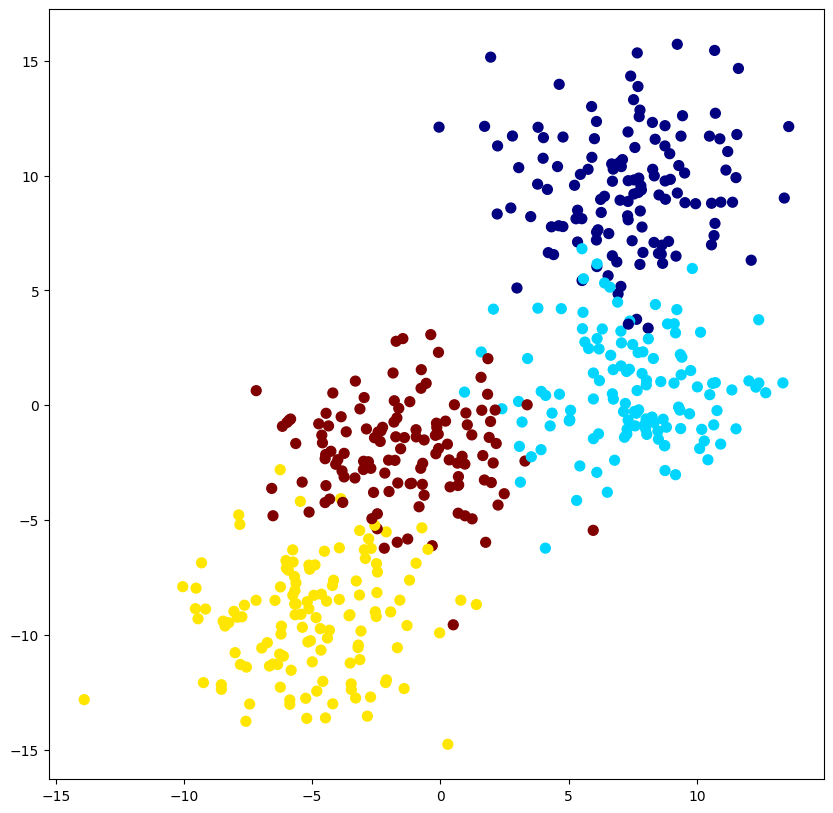

In [24]:
#Scatter plot the points
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')

### 描画のための関数

In [25]:
def visualize_tree(classifier, X, y, boundaries=True,xlim=None, ylim=None):
    '''
    決定木の可視化をします。
    INPUTS: 分類モデル, X, y, optional x/y limits.
    OUTPUTS: Meshgridを使った決定木の可視化
    '''
    # 軸を自動調整
    if xlim is None:
        xlim = (X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    if ylim is None:
        ylim = (X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    x_min, x_max = xlim
    y_min, y_max = ylim
    
    
    # meshgridをつくります。
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # 分類器の予測をZとして保存
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # meshgridを使って、整形します。
    Z = Z.reshape(xx.shape)
    
    # 分類ごとに色を付けます。
    plt.figure(figsize=(10,10))
    plt.pcolormesh(xx, yy, Z, alpha=0.2, cmap='jet')
    
    # 訓練データも描画します。
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)        
    
    def plot_boundaries(i, xlim, ylim):
        '''
        境界線を描き込みます。
        '''
        if i < 0:
            return

        tree = classifier.tree_
        
        # 境界を描画するために、再帰的に呼び出します。
        if tree.feature[i] == 0:
            plt.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k')
            plot_boundaries(tree.children_left[i],
                            [xlim[0], tree.threshold[i]], ylim)
            plot_boundaries(tree.children_right[i],
                            [tree.threshold[i], xlim[1]], ylim)
        
        elif tree.feature[i] == 1:
            plt.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k')
            plot_boundaries(tree.children_left[i], xlim,
                            [ylim[0], tree.threshold[i]])
            plot_boundaries(tree.children_right[i], xlim,
                            [tree.threshold[i], ylim[1]])
    
    if boundaries:
        plot_boundaries(0, plt.xlim(), plt.ylim())

深さ2の決定木を作ります。

In [26]:
from sklearn import tree

# モデルを作ります。
clf = tree.DecisionTreeClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=0)

[Text(0.5, 0.8333333333333334, 'x[0] <= 2.192\ngini = 0.75\nsamples = 500\nvalue = [125, 125, 125, 125]'),
 Text(0.25, 0.5, 'x[1] <= -5.072\ngini = 0.523\nsamples = 251\nvalue = [3, 3, 125, 120]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.103\nsamples = 128\nvalue = [0, 0, 121, 7]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.154\nsamples = 123\nvalue = [3, 3, 4, 113]'),
 Text(0.75, 0.5, 'x[1] <= 4.666\ngini = 0.519\nsamples = 249\nvalue = [122, 122, 0, 5]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.123\nsamples = 124\nvalue = [3, 116, 0, 5]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.091\nsamples = 125\nvalue = [119, 6, 0, 0]')]

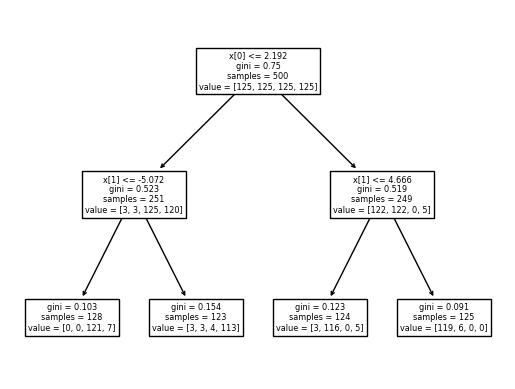

In [27]:
# 木構造を描画します。
# valueはそれぞれのクラスに属するデータの数
tree.plot_tree(clf)

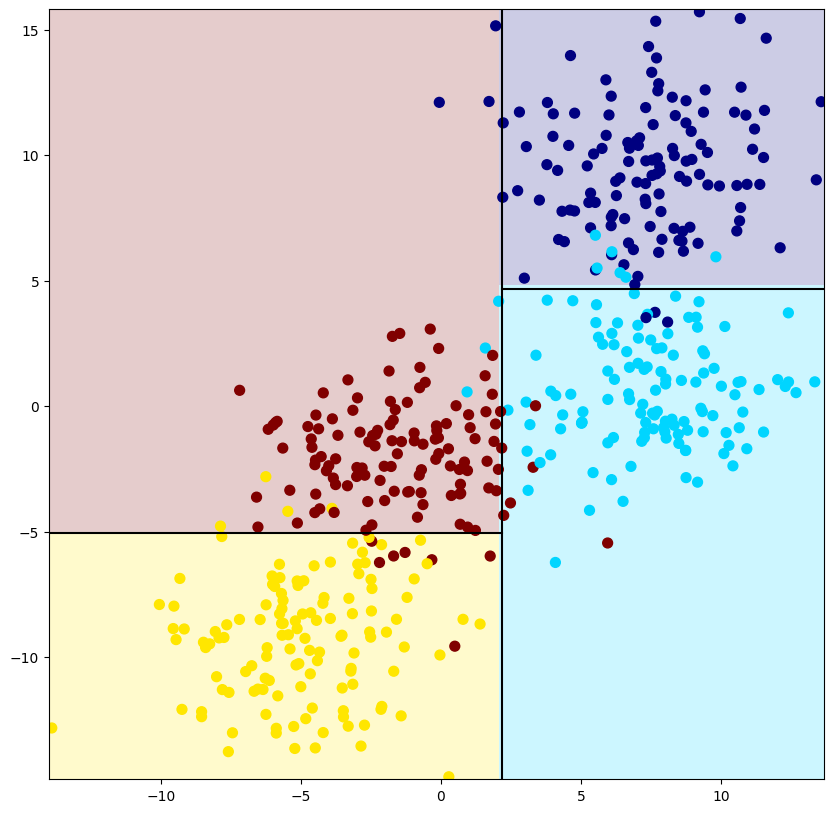

In [28]:
# 描画します。
visualize_tree(clf, X, y)

In [29]:
# 深さを4にしてみます
clf = tree.DecisionTreeClassifier(max_depth=4, random_state=0)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=4, random_state=0)

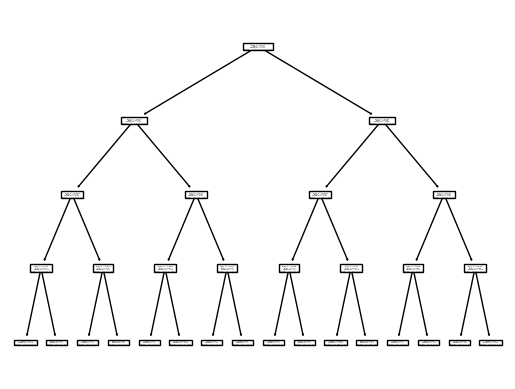

In [30]:
_ = tree.plot_tree(clf)

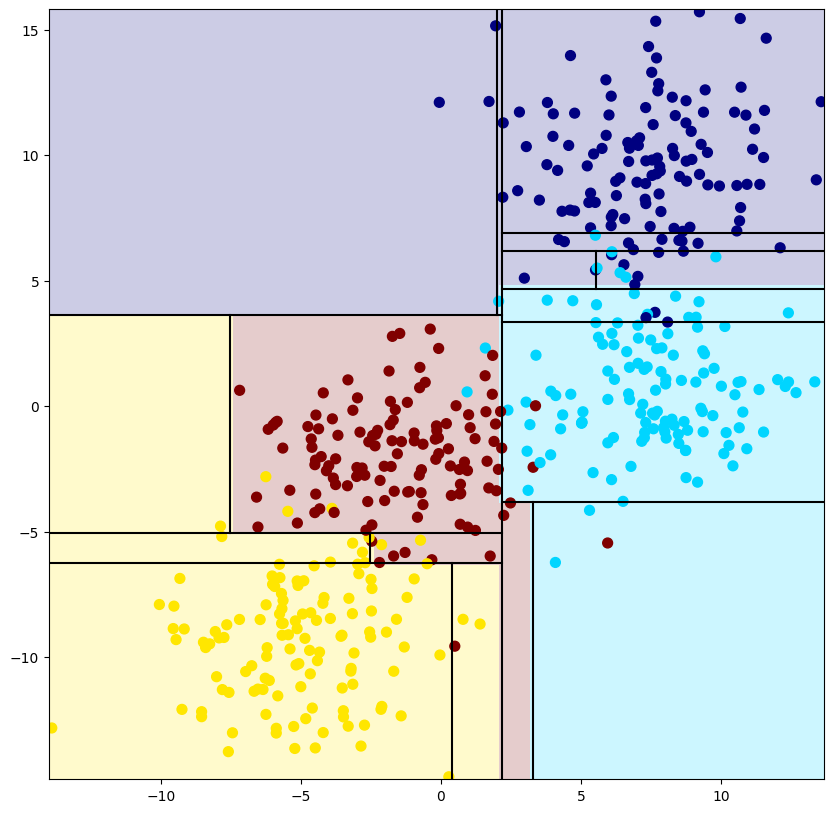

In [31]:
visualize_tree(clf, X, y)

あまりにも細かく分類すると、過学習（over fitting）の問題が起こります。

## Random Forests

過学習の問題を回避するための一つの方法が、ランダムフォレストです。

ランダムフォレストは、学習データの一部をランダムに選んで、決定木を作ります。これを繰り返すことによって、色々な種類の木が出来るので、汎化性能が下がるのを避けることができるわけです。

In [32]:
from sklearn.ensemble import RandomForestClassifier

# n_estimatorsは、作る木の数です。
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)

RandomForestClassifier(random_state=0)

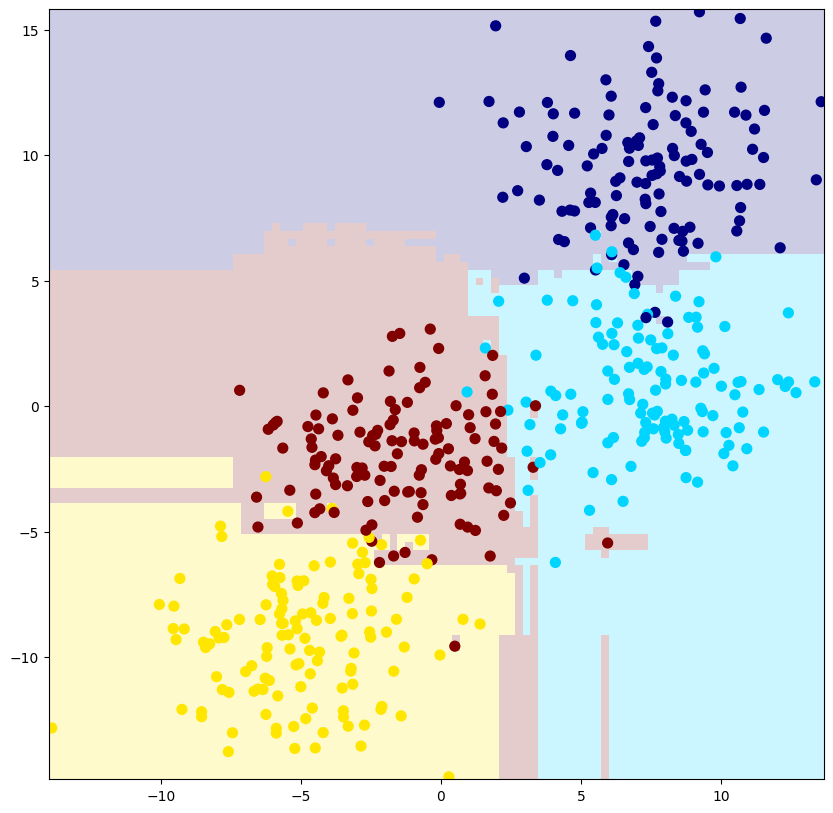

In [33]:
# 境界線を書かないようにします。
visualize_tree(clf, X, y, boundaries=False)

In [34]:
# 変数の重要度がわかります。
clf.feature_importances_

array([0.39265795, 0.60734205])

## Random Forest Regression
ランダムフォレストは、分類だけではなく、回帰にも使うことができます。

ダミーのデータを作って、試してみましょう。

<ErrorbarContainer object of 3 artists>

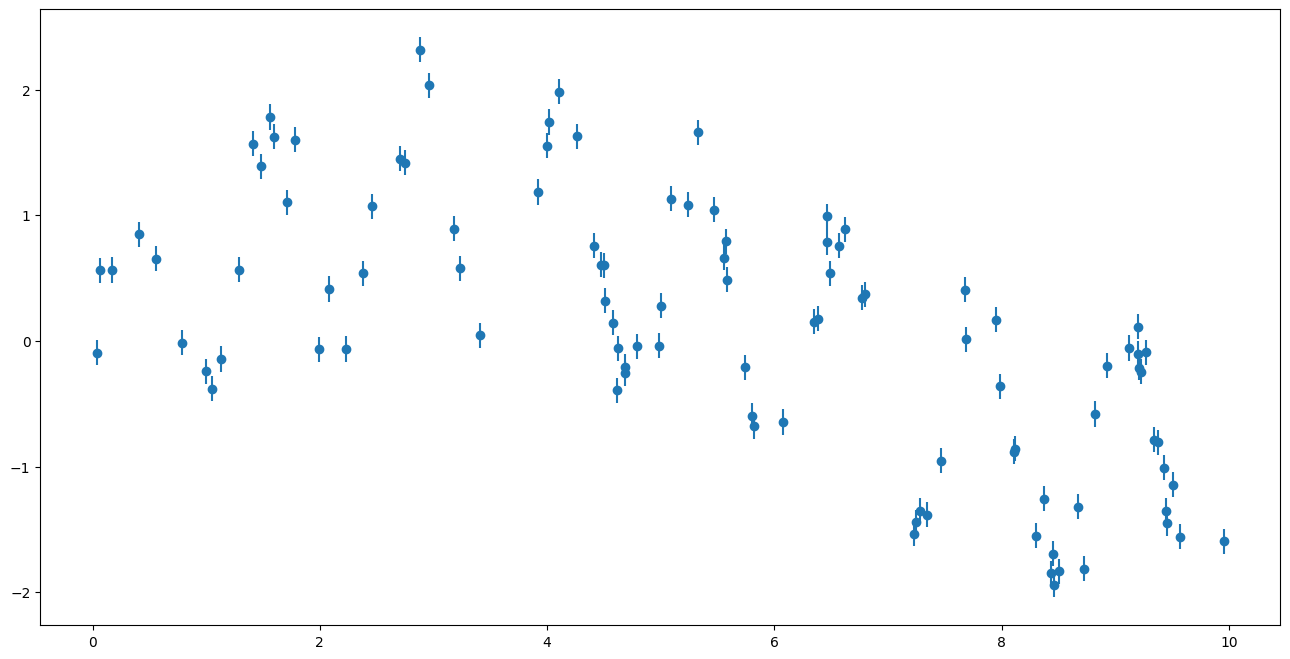

In [35]:
from sklearn.ensemble import RandomForestRegressor

x = 10 * np.random.rand(100)

def sin_model(x, sigma=0.2):
    '''
    大きな波＋小さな波＋ノイズからなるダミーデータです。
    '''
    noise = sigma * np.random.randn(len(x))
    return np.sin(5 * x) + np.sin(0.5 * x) + noise

# xからyを計算
y = sin_model(x)

# Plotします。
plt.figure(figsize=(16,8))
plt.errorbar(x, y, 0.1, fmt='o')

このデータを単純な線形回帰で予測しようとしても難しいのは、一目瞭然です。
そこで、ランダムフォレストを使って見ることにしましょう。

In [36]:
# まずはデータの変形
X = x.reshape((-1, 1))
X

array([[9.19717843],
       [3.99762213],
       [8.45909182],
       [6.38882899],
       [2.88161585],
       [6.45935863],
       [8.10537421],
       [8.4531405 ],
       [1.05197977],
       [9.95624347],
       [6.34538015],
       [9.11755373],
       [2.7539737 ],
       [7.46676165],
       [1.41007462],
       [4.01806784],
       [4.26498495],
       [4.62240847],
       [8.11876432],
       [9.22593403],
       [5.23621068],
       [9.43332267],
       [2.70997233],
       [1.13200779],
       [1.78303396],
       [9.20888741],
       [0.78877951],
       [8.93213526],
       [9.19954666],
       [5.57367638],
       [8.4321267 ],
       [4.78895777],
       [6.07229126],
       [8.72520832],
       [1.293152  ],
       [6.77180243],
       [4.99877202],
       [7.23249602],
       [7.67766155],
       [9.26754155],
       [2.37889489],
       [9.57426038],
       [4.50758162],
       [8.30621776],
       [5.3249681 ],
       [6.49268497],
       [3.91706459],
       [2.962

In [37]:
x

array([9.19717843, 3.99762213, 8.45909182, 6.38882899, 2.88161585,
       6.45935863, 8.10537421, 8.4531405 , 1.05197977, 9.95624347,
       6.34538015, 9.11755373, 2.7539737 , 7.46676165, 1.41007462,
       4.01806784, 4.26498495, 4.62240847, 8.11876432, 9.22593403,
       5.23621068, 9.43332267, 2.70997233, 1.13200779, 1.78303396,
       9.20888741, 0.78877951, 8.93213526, 9.19954666, 5.57367638,
       8.4321267 , 4.78895777, 6.07229126, 8.72520832, 1.293152  ,
       6.77180243, 4.99877202, 7.23249602, 7.67766155, 9.26754155,
       2.37889489, 9.57426038, 4.50758162, 8.30621776, 5.3249681 ,
       6.49268497, 3.91706459, 2.96289681, 9.457641  , 4.58020582,
       4.98391532, 2.08480628, 4.61638721, 4.68615775, 7.34574689,
       1.48022231, 3.40699309, 5.82522642, 7.27960394, 6.80182068,
       7.24359115, 4.49912304, 2.23371121, 1.71289236, 4.47744788,
       9.37600836, 8.67375317, 8.50954303, 0.16737383, 0.55592424,
       9.45029226, 3.18296101, 9.34165061, 5.80355914, 6.62008

In [38]:
# 回帰モデルを用意します。
rfr = RandomForestRegressor()

# モデルを学習させます。
rfr.fit(X, y)

RandomForestRegressor()

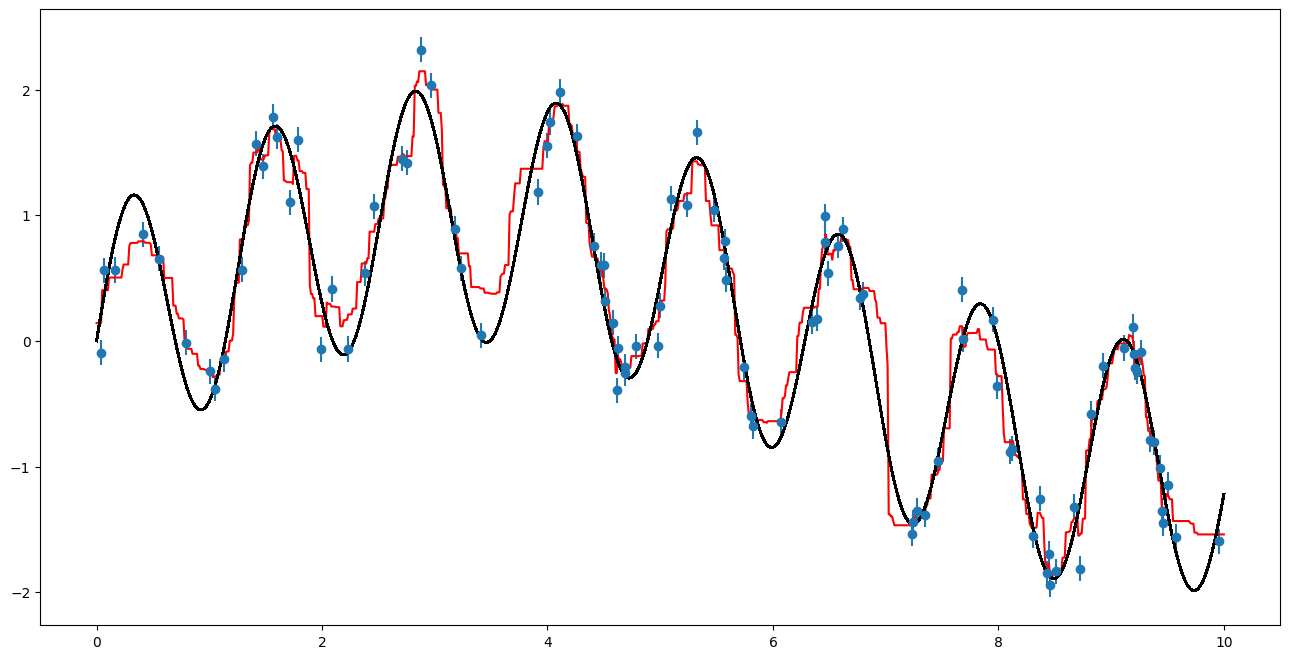

In [39]:
# テスト用の入力データを用意します。
xfit = np.linspace(0, 10, 1000).reshape((-1, 1))

# 予測値を計算します。
yfit = rfr.predict(xfit)

# 実際の値です。
ytrue = sin_model(xfit, 0)

# Plot します
plt.figure(figsize=(16,8))

plt.errorbar(x, y, 0.1, fmt='o')

plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);


ランダムフォレストは、このように分類だけでは無く、回帰にも使えるので、非常に応用範囲が広い方法論です。また、XGBoostなど実用的にもかなり性能のよいモデルのもとになっています。各説明変数の重要度を数値化してくれる、feature importanceも便利です。実際のデータを使ってRandom Forestsを使ってみてください。